In [1]:
import xgboost
xgboost.__version__

'1.4.2'

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score, mean_absolute_percentage_error



from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.options.display.max_columns = None
pd.options.display.float_format = "{:,.4f}".format



In [3]:
def plot_scatter_chart(df_plot, target_col):
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    n_axs = len(columns_to_plot)
    n_cols = 4
    n_rows = n_axs//n_cols
    if n_axs%n_cols>0:
        n_rows = n_rows + 1 
    fig  =  plt.figure(figsize=(n_cols*4, n_rows*4), linewidth=3, edgecolor='grey')
    for i, col in enumerate(columns_to_plot):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.regplot(x=col, y=target_col, data=df_plot, ax=ax, scatter_kws={'alpha':0.8}, line_kws={'color':'orange'})
    plt.show()  

    
    
def get_regression_features(df_plot, target_col):
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        m, b = np.polyfit(df_plot[col], df_plot[target_col], 1)
        results[col] = m
    return results
    
def get_correlation_of_continuous_features(df_plot, target_col):
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        results[col] = np.corrcoef(x = df_plot[col], y=df_plot[target_col])[0, 1]
    return results    

def get_correlation_of_categorical_features(df_plot, target_col):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        model = ols(target_col + '~' + col, data = df_plot).fit()
        result_anova = sm.stats.anova_lm(model)
        results[col] = result_anova.loc[col, 'PR(>F)']
    return results
    
def get_correlation_of_categorical_features_1(df_plot, target_col):
    from scipy import stats 
    columns_to_plot = list(df_plot.columns)
    columns_to_plot.remove(target_col)
    results = {}
    for col in columns_to_plot:
        category_group_list=df_plot.groupby(col)[target_col].apply(list)
        results[col] = stats.f_oneway(*category_group_list)[1]
    return results    
   

def get_chi_correlation_of_categorical_features(df_plot):
    from scipy.stats import chi2_contingency
    df_result = pd.DataFrame()
    col_list = sorted(list(df_plot.columns))
    for col in sorted(list(df_plot.columns)):
#        col_list.remove(col)
        for col_i in col_list:
            if col!=col_i:
                data=df_plot[[col, col_i]].groupby([col, col_i]).size().unstack()
                df_result.loc[col, col_i] = chi2_contingency(data)[1]
            else:
                df_result.loc[col, col_i] = 0
    return df_result


        
    

In [4]:
#df = pd.read_csv('Data_Set.csv', low_memory=False, index_col='custid')


df = pd.read_csv('Data_Set.csv', low_memory=False)

#df.index = df['custid']

#df_cluster = pd.read_csv('clusters.csv')
#df = pd.concat([df, df_cluster], axis=1)

In [5]:
df[['region', 'income']].median()

region    3.0000
income   38.0000
dtype: float64

In [6]:
log_columns = list(filter(lambda x:x.startswith('ln'), df.columns))
df.drop(columns=log_columns, inplace=True)

df.loc[:, ['total_spent']] = df['cardspent'] + df['card2spent']
df.loc[:, ['debtinc']] =  df['debtinc']*df['income']/100.0
df.drop(['cardspent', 'card2spent'], axis=1, inplace=True)

df.drop(columns=['custid', 'birthmonth'], inplace=True)

df.replace('#NULL!', np.nan, inplace=True)
df.fillna(df[~df.isna()].median().iloc[0], inplace=True)

df['carvalue'].replace(-np.inf, 0.001, inplace=True)
df['carvalue'].replace(-1, 0.001, inplace=True)


In [7]:
df.isna().sum().sum()

0

In [8]:

#df.loc[:, ['cardmon_total']] = df[['cardmon', 'wiremon', 'longmon', 'equipmon', 'tollmon']].sum(axis=1) 
#df.loc[:, ['cardten_total']] = df[['cardten', 'wireten', 'longten', 'equipten', 'tollten']].sum(axis=1)#/(df['tenure']*1.0)
#df.loc[:, ['have_car']] = df[['carbought', 'carbuy']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

features_own_tv = list(filter(lambda x: x.lower().find('own')==0, df.columns))
#df.loc[:, 'own_tv_set_1'] = df[features_own_tv[:4]].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
#df.loc[:, 'own_tv_set_2'] = df[features_own_tv[4:]].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

#df.loc[:, ['debt_total']] = df[['creddebt', 'othdebt']].sum(axis=1)


features_pets = [x for x in df.columns if x.lower().startswith('pets') and x.lower()!='pets']
df.drop(features_pets, axis=1, inplace=True)


#df.drop(['cardten', 'wireten', 'longten', 'equipten', 'tollten'], axis=1, inplace=True)
#df.drop(['cardmon', 'wiremon', 'longmon', 'equipmon', 'tollmon'], axis=1, inplace=True)
df.drop(['callcard', 'wireless', 'equip', 'tollfree'], axis=1, inplace=True)

#df.drop(columns=['region', 'townsize'], inplace=True)
df.drop(columns=[ 'gender'], inplace=True)
df.drop(columns=['polview', 'polparty', 'polcontrib', 'vote',
                 'cardbenefit', 'card2benefit', 'churn', 'multline', 'voice', 'news'
                , 'response_01', 'response_02', 'response_03'], inplace=True)

df.drop(columns=['cardfee', 'card2fee'], inplace=True)
df.drop(columns=['cardtype', 'card2type'], inplace=True)

df.drop(columns=['pager'], inplace=True)
df.drop(columns=['active', 'bfast', 'internet', 'callid', 'callwait', 'forward', 'confer', 'ebill'], inplace=True)

df.drop(columns=['tenure'], inplace=True)
df.drop(['homeown', 'hometype'], axis=1, inplace=True)
df.drop(['spousedcat', 'edcat'], axis=1, inplace=True)
df.drop(['spoused'], axis=1, inplace=True)
df.drop(['addresscat'], axis=1, inplace=True)
df.drop(['address'], axis=1, inplace=True)
#df.drop(['inccat'], axis=1, inplace=True)
#df.drop(columns=['union', 'retire', 'carown'], inplace=True)

commute_to_drop = [x for x in df.columns if 'commute' in x.lower() and x.lower() not in ['commutecat']]
df.drop(columns=commute_to_drop, inplace=True)

df.drop(columns=['carbought', 'carbuy'], inplace=True)

df.drop(['default', 'marital'], axis=1, inplace=True)
#df.drop(features_own_tv, axis=1, inplace=True)


#df.drop(columns=['othdebt'], inplace=True)
#df.drop(columns=['creddebt'], inplace=True)

#df.drop(['carvalue'], axis=1, inplace=True)
#df.drop(['age'], axis=1, inplace=True)
df.drop(['employ'], axis=1, inplace=True)

df.drop(columns=['age', 'empcat', 'jobsat'], inplace=True)

df.drop(columns=['carcatvalue', 'cardtenurecat', 'card2tenurecat'], inplace=True)

df.drop(['cardtenure', 'card2tenure'], axis=1, inplace=True)

df.drop(['hourstv'], axis=1, inplace=True)





In [9]:
X = df.drop(columns=['total_spent']).copy()
y = df['total_spent'].copy()
X.replace('#NULL!', np.nan, inplace=True) 
X.fillna(X.mean(), inplace=True)
X.fillna(0, inplace=True)
X = X.convert_dtypes()
cols = X.select_dtypes(float).columns
X[cols] = X[cols].astype(np.float64)
cols = X.select_dtypes(int).columns
X[cols] = X[cols].astype(np.int64)
cols = X.select_dtypes('object').columns
X[cols] = X[cols].astype(np.float64)


In [10]:
act_sum = X.select_dtypes(np.number).sum()
int_sum = X.select_dtypes(np.number).astype(np.int64).sum()

int_columns = X.select_dtypes(np.number).columns[act_sum/int_sum==1]
float_columns = X.select_dtypes(np.number).columns[act_sum/int_sum!=1]
X.loc[:, int_columns] = X[int_columns].astype(np.int64)
X.loc[:, float_columns] = X[float_columns].astype(np.float64)

cat_columns = [col for col in X.columns if X[col].unique().size <= 70]
cont_columns = [col for col in X.select_dtypes(include=[np.number]).columns if col not in cat_columns]

X.loc[:, cat_columns] = X[cat_columns].astype(np.float64).astype(np.int64).astype('category')

In [11]:
from sklearn import preprocessing
pt = PowerTransformer()
transformer_y = PowerTransformer()
sc = StandardScaler()
#X.loc[:, cont_columns] = pt.fit_transform(sc.fit_transform(X[cont_columns]))
#y = pd.Series(pt.fit_transform(sc.fit_transform(y.values.reshape(-1, 1))).reshape(-1), name='total_spent')


X.loc[:, cont_columns] = np.log1p(X[cont_columns])
y = np.log1p(y)

In [12]:
cont_columns

['income',
 'debtinc',
 'creddebt',
 'othdebt',
 'carvalue',
 'longmon',
 'longten',
 'tollmon',
 'tollten',
 'equipmon',
 'equipten',
 'cardmon',
 'cardten',
 'wiremon',
 'wireten']

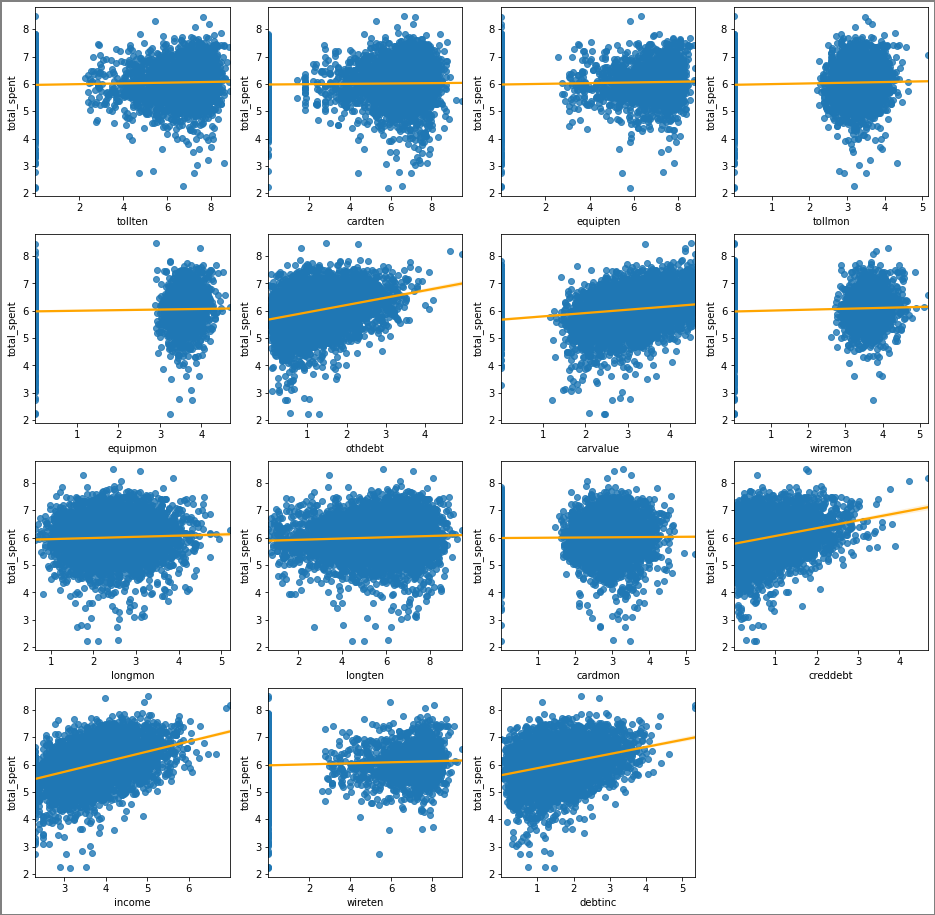

In [13]:
df_plot = pd.concat([X, y], axis=1)
target_col = 'total_spent'
df_plot_local=df_plot[cont_columns + [target_col]]
cols_to_plot = list(df_plot_local.columns)
cols_to_plot = list(set(cols_to_plot))
plot_scatter_chart(df_plot_local[cols_to_plot]+0.001, target_col)

In [14]:
cont_columns_selected  = [
 'income',
 'debtinc',
 'creddebt',
 'othdebt',
 'carvalue',
 'longmon',
]

In [15]:
results = get_regression_features(df_plot[cont_columns + [target_col]], target_col)
dict_cont_columns = {x:y for x,y in results.items() if np.abs(y)>=0.05}
cont_columns_selected = list(dict_cont_columns.keys())
#cont_columns_selected = cont_columns
cont_columns_selected

['income', 'debtinc', 'creddebt', 'othdebt', 'carvalue']

In [16]:
#cont_columns_selected - ['age', 'equipmon', 'cardmon', 'tenure', ]

In [17]:
set(cont_columns) - set(cont_columns_selected)

{'cardmon',
 'cardten',
 'equipmon',
 'equipten',
 'longmon',
 'longten',
 'tollmon',
 'tollten',
 'wiremon',
 'wireten'}

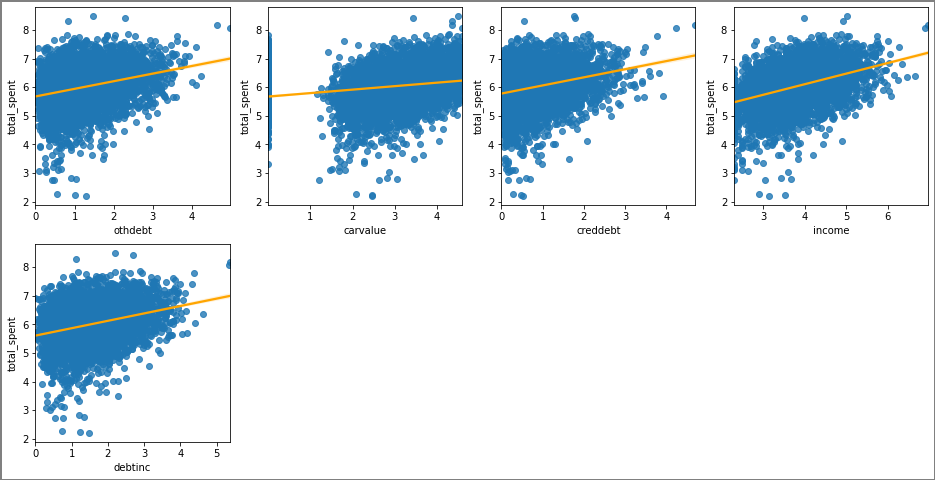

In [18]:
df_plot = pd.concat([X, y], axis=1)
target_col = 'total_spent'
df_plot_local=df_plot[cont_columns_selected + [target_col]]
cols_to_plot = list(df_plot_local.columns)
cols_to_plot = list(set(cols_to_plot))
plot_scatter_chart(df_plot_local[cols_to_plot], target_col)

In [19]:
if 'birthmonth' in cat_columns:
    cat_columns.remove('birthmonth')
results = get_correlation_of_categorical_features(df_plot[cat_columns + [target_col]], target_col)
#dict_cat_columns_eligible = {x:y for x,y in results.items() if np.abs(y)<=200}
dict_cat_columns_eligible = {x:y for x,y in results.items() if np.abs(y)<= 0.05}
cat_columns_selected = list(dict_cat_columns_eligible.keys())

#cat_columns_selected  = cat_columns

In [20]:
pd.Series(results).sort_values(ascending=False)

townsize     0.9111
reside       0.8032
commutecat   0.4243
cars         0.2811
cartype      0.1806
pets         0.1325
union        0.1107
region       0.0989
owngame      0.0023
ownipod      0.0022
ownpc        0.0020
ownfax       0.0000
ownpda       0.0000
jobcat       0.0000
ed           0.0000
owntv        0.0000
owncd        0.0000
reason       0.0000
carown       0.0000
ownvcr       0.0000
agecat       0.0000
owndvd       0.0000
card2        0.0000
retire       0.0000
card         0.0000
inccat       0.0000
dtype: float64

In [21]:
target_col = 'total_spent'

df_plot_local=df_plot[list(dict_cat_columns_eligible.keys())]
results = get_chi_correlation_of_categorical_features(df_plot_local)



In [22]:
results.replace('NaN', 0)

,agecat,card,card2,carown,ed,inccat,jobcat,owncd,owndvd,ownfax,owngame,ownipod,ownpc,ownpda,owntv,ownvcr,reason,retire
agecat,0.0000,0.0000,0.0017,0.0000,0.0000,0.0000,0.0396,0.0000,0.0000,0.0012,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7082,0.0000
card,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6369,0.0498,0.0004,0.0000,0.0000,0.0000,0.0000,0.0000,0.1741,0.0208,0.0000,0.0001
card2,0.0017,0.0000,0.0000,0.0454,0.0000,0.0000,0.6392,0.0001,0.0000,0.0059,0.0002,0.0047,0.0000,0.0001,0.0007,0.0001,0.2158,0.0029
carown,0.0000,0.0000,0.0454,0.0000,0.0022,0.0000,0.0019,0.0000,0.0000,0.0007,0.0000,0.0000,0.0713,0.0000,0.0000,0.0000,0.1789,0.0000
ed,0.0000,0.0000,0.0000,0.0022,0.0000,0.0000,0.0302,0.0017,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.4877,0.0000,0.1141,0.0000
inccat,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0015,0.0004,0.0046,0.0000,0.0000,0.0000,0.1114,0.0000
jobcat,0.0396,0.6369,0.6392,0.0019,0.0302,0.0000,0.0000,0.0001,0.0001,0.3796,0.0014,0.3956,0.0138,0.0067,0.0033,0.0000,0.3457,0.0000
owncd,0.0000,0.0498,0.0001,0.0000,0.0017,0.0000,0.0001,0.0000,0.0000,0.0005,0.3069,0.2822,0.6292,0.0030,0.0000,0.0000,0.8470,0.0000
owndvd,0.0000,0.0004,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0095,0.3853,0.9610,0.5399,0.0015,0.0000,0.0000,0.3312,0.0000
ownfax,0.0012,0.0000,0.0059,0.0007,0.0000,0.0000,0.3796,0.0005,0.0095,0.0000,0.0000,0.0000,0.0000,0.0000,0.1798,0.0171,0.7604,0.0000


In [23]:
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.feature_selection import chi2
def get_chi_correlation_of_categorical_features_1(df_plot):

    df_result = pd.DataFrame()
    col_list = sorted(list(df_plot.columns))
    for col in sorted(list(df_plot.columns)):
#        col_list.remove(col)
        for col_i in col_list:
            if col!=col_i:
                df_result.loc[col, col_i] = chi2(np.abs(np.array(df_plot[col]).reshape(-1, 1)), np.abs(np.array(df_plot[col_i]).reshape(-1, 1)))[1]
            else:
                df_result.loc[col, col_i] = 0
    return df_result


target_col = 'total_spent'

df_plot_local=df_plot[list(dict_cat_columns_eligible.keys())]
results = get_chi_correlation_of_categorical_features_1(df_plot_local)


In [24]:
results

,agecat,card,card2,carown,ed,inccat,jobcat,owncd,owndvd,ownfax,owngame,ownipod,ownpc,ownpda,owntv,ownvcr,reason,retire
agecat,0.0000,0.2881,0.7576,0.0000,0.0001,0.0000,0.3047,0.0004,0.0000,0.1877,0.0000,0.0000,0.0000,0.0075,0.0071,0.0000,0.8970,0.0000
card,0.9105,0.0000,0.0000,0.8031,0.8944,0.8164,0.9147,0.9173,0.8898,0.9018,0.4755,0.7936,0.1609,0.5237,0.4771,0.8435,0.0000,0.4666
card2,0.2459,0.0000,0.0000,0.0896,0.0403,0.0014,0.9055,0.0112,0.0415,0.8887,0.0846,0.2659,0.6958,0.3483,0.0122,0.0101,0.9341,0.0671
carown,0.0000,0.2689,0.7818,0.0000,0.9747,0.0000,0.6857,0.0000,0.0000,0.1274,0.1125,0.0738,0.3599,0.0356,0.0011,0.0002,0.8409,0.0000
ed,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0012,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0897,0.0001,0.9160,0.0000
inccat,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0094,0.0120,0.0035,0.0000,0.0000,0.0000,0.5415,0.0000
jobcat,0.0145,0.4385,0.5118,0.6499,0.0003,0.0000,0.0000,0.1027,0.3755,0.5334,0.0002,0.0464,0.0050,0.4885,0.7926,0.0628,0.4421,0.0000
owncd,0.0023,0.9587,0.8117,0.0081,1.0000,0.0000,0.8810,0.0000,0.0000,0.3575,0.7798,0.7692,0.8884,0.4313,0.0000,0.0000,0.9990,0.0024
owndvd,0.0000,0.7805,0.7016,0.0012,0.9994,0.0000,0.8101,0.0000,0.0000,0.4345,0.7871,0.9767,0.8450,0.3402,0.0000,0.0000,0.9827,0.0013
ownfax,0.0050,0.0000,0.0181,0.0005,0.0000,0.0000,0.4991,0.0013,0.0160,0.0000,0.0000,0.0000,0.0000,0.0000,0.1787,0.0264,0.8209,0.0000


In [25]:
set(cat_columns) - set(cat_columns_selected)

{'cars',
 'cartype',
 'commutecat',
 'pets',
 'region',
 'reside',
 'townsize',
 'union'}

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()

In [27]:
#X_train = X_train[cont_columns_selected + cat_columns_selected]
#X_test = X_test[cont_columns_selected + cat_columns_selected]

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train[cat_columns_selected])
col_names = ohe.get_feature_names(cat_columns_selected)

df_ohe = pd.DataFrame(ohe.transform(X_train[cat_columns_selected]), columns=col_names, index=X_train.index)
X_train.drop(columns=cat_columns_selected, inplace=True)
X_train = pd.concat([X_train, df_ohe], axis=1)
                                            
df_ohe = pd.DataFrame(ohe.transform(X_test[cat_columns_selected]), columns=col_names, index=X_test.index)
X_test.drop(columns=cat_columns_selected, inplace=True)
X_test = pd.concat([X_test, df_ohe], axis=1)

D:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
D:\Programs\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [28]:
X_train.shape, X_test.shape

((3500, 95), (1500, 95))

In [29]:
X_train

,region,townsize,union,income,debtinc,creddebt,othdebt,reside,pets,cars,cartype,carvalue,commutecat,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,agecat_2,agecat_3,agecat_4,agecat_5,agecat_6,ed_6,ed_7,ed_8,ed_9,ed_10,ed_11,ed_12,ed_13,ed_14,ed_15,ed_16,ed_17,ed_18,ed_19,ed_20,ed_21,ed_22,ed_23,jobcat_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,retire_0,retire_1,inccat_1,inccat_2,inccat_3,inccat_4,inccat_5,carown_-1,carown_0,carown_1,reason_1,reason_2,reason_3,reason_4,reason_9,card_1,card_2,card_3,card_4,card_5,card2_1,card2_2,card2_3,card2_4,card2_5,owntv_0,owntv_1,ownvcr_0,ownvcr_1,owndvd_0,owndvd_1,owncd_0,owncd_1,ownpda_0,ownpda_1,ownpc_0,ownpc_1,ownipod_0,ownipod_1,owngame_0,owngame_1,ownfax_0,ownfax_1
1840,2,4,0,3.4012,1.0695,0.2311,0.9783,5,2,2,0,2.7213,4,1.9021,5.0278,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000
2115,1,2,0,4.9904,2.5284,1.8547,1.9671,1,0,3,0,4.3464,1,2.8931,6.9854,3.1884,7.2567,0.0000,0.0000,3.3844,7.3531,3.4766,7.5191,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000
4437,1,2,0,2.4849,0.4662,0.2151,0.3001,3,0,4,1,1.8245,1,2.6912,6.8401,3.4965,7.7253,0.0000,0.0000,3.1023,7.3337,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000
1146,3,3,0,3.8712,0.7100,0.1484,0.6313,2,3,5,0,2.6946,1,2.1401,4.6279,0.0000,0.0000,3.3517,5.8090,0.0000,0.0000,2.9907,5.4243,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000
2486,3,1,0,3.9120,1.8076,1.5390,0.8920,1,3,4,0,3.0350,1,2.4973,6.4407,3.3232,7.3786,0.0000,0.0000,4.1150,8.0774,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [30]:
#y_train = transformer_y.fit_transform(y_train.values.reshape(-1, 1))
#y_test = transformer_y.transform(y_test.values.reshape(-1, 1))

#y_train = transformer_y.fit_transform(scaler_y.fit_transform(y_train.values.reshape(-1, 1)))
#y_test = transformer_y.transform(scaler_y.transform(y_test.values.reshape(-1, 1)))

#y_train = np.log1p(y_train)
#y_test = np.log1p(y_test)

In [31]:
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

svr_model = SVR()
linear_svr_model = LinearSVR(random_state=42)
lr_model = LinearRegression()
xgb_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, random_state=42)
ridge_model = Ridge(random_state = 42)
lasso_model = Lasso(random_state = 42)
knn_model = KNeighborsRegressor(5,weights='uniform')
bay_model = BayesianRidge()
dec_model = DecisionTreeRegressor(random_state = 42)
rf_model = RandomForestRegressor(n_estimators = 300, random_state = 42)


model_list = [lr_model, bay_model, ridge_model, lasso_model,
              linear_svr_model, svr_model, xgb_model, knn_model,
              dec_model, rf_model]

#model_list=[lr_model]

for model in model_list:
    print(str(model).split('(')[0])
    model.fit(X_train.values, y_train.ravel())


LinearRegression
BayesianRidge
Ridge
Lasso
LinearSVR


D:\Programs\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVR
XGBRegressor
KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor


In [32]:
def check_model_accuracy(model_list, X_train, X_test, y_train, y_test):
    df_result = pd.DataFrame(columns=['r2_score train',
                                      'mape train',
                                      'explained variance train',
                                      'rmse train',
                                      'mae train',
                                      'med absolute error train',
                                      'r2_score test',
                                      'mape test',
                                      'explained variance test',                                      
                                      'rmse test',
                                      'mae test',
                                      'med absolute error test'
                                     ] )
    
    for model in model_list:
        model_name = str(model).split('(')[0]
        print(model_name)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        df_result.loc[model_name] = np.array([r2_score(y_train, y_train_pred),
                                              mean_absolute_percentage_error(y_train, y_train_pred),                                              
                                              explained_variance_score(y_train, y_train_pred),
                                              mean_squared_error(y_train, y_train_pred, squared=True), 
                                              mean_absolute_error(y_train, y_train_pred), 
                                              median_absolute_error(y_train, y_train_pred), 
                                              r2_score(y_test, y_test_pred),
                                              mean_absolute_percentage_error(y_test, y_test_pred),
                                              explained_variance_score(y_test, y_test_pred),
                                              mean_squared_error(y_test, y_test_pred, squared=True), 
                                              median_absolute_error(y_test, y_test_pred),
                                              mean_absolute_error(y_test, y_test_pred)
                                             ])
    return df_result

In [33]:
check_model_accuracy(model_list, X_train, X_test, y_train, y_test)

LinearRegression
BayesianRidge
Ridge
Lasso
LinearSVR
SVR
XGBRegressor
KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor


,r2_score train,mape train,explained variance train,rmse train,mae train,med absolute error train,r2_score test,mape test,explained variance test,rmse test,mae test,med absolute error test
LinearRegression,0.3512,0.0735,0.3512,0.2940,0.4166,0.3443,0.3114,0.0740,0.3118,0.2970,0.3553,0.4251
BayesianRidge,0.3495,0.0734,0.3495,0.2948,0.4162,0.3393,0.3135,0.0739,0.3139,0.2961,0.3583,0.4242
Ridge,0.3512,0.0735,0.3512,0.2940,0.4166,0.3441,0.3116,0.0740,0.3120,0.2969,0.3551,0.4250
Lasso,0.0000,0.0897,0.0000,0.4532,0.5085,0.4030,-0.0002,0.0886,0.0000,0.4314,0.4035,0.5085
LinearSVR,0.1395,0.0867,0.3085,0.3900,0.4773,0.3817,0.1186,0.0852,0.2792,0.3802,0.3846,0.4732
SVR,0.3851,0.0688,0.3872,0.2787,0.3853,0.2848,0.2807,0.0754,0.2818,0.3102,0.3394,0.4297
XGBRegressor,1.0000,0.0001,1.0000,0.0000,0.0005,0.0004,0.2086,0.0788,0.2098,0.3414,0.3686,0.4545
KNeighborsRegressor,0.3120,0.0752,0.3126,0.3118,0.4301,0.3505,0.0033,0.0887,0.0048,0.4299,0.4217,0.5126
DecisionTreeRegressor,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,-0.4683,0.1071,-0.4647,0.6333,0.5112,0.6230
RandomForestRegressor,0.9022,0.0285,0.9023,0.0443,0.1624,0.1292,0.2685,0.0755,0.2703,0.3155,0.3593,0.4353


In [34]:
sorted(list(X_train.columns))

['agecat_2',
 'agecat_3',
 'agecat_4',
 'agecat_5',
 'agecat_6',
 'card2_1',
 'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card_1',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'cardmon',
 'cardten',
 'carown_-1',
 'carown_0',
 'carown_1',
 'cars',
 'cartype',
 'carvalue',
 'commutecat',
 'creddebt',
 'debtinc',
 'ed_10',
 'ed_11',
 'ed_12',
 'ed_13',
 'ed_14',
 'ed_15',
 'ed_16',
 'ed_17',
 'ed_18',
 'ed_19',
 'ed_20',
 'ed_21',
 'ed_22',
 'ed_23',
 'ed_6',
 'ed_7',
 'ed_8',
 'ed_9',
 'equipmon',
 'equipten',
 'inccat_1',
 'inccat_2',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'income',
 'jobcat_1',
 'jobcat_2',
 'jobcat_3',
 'jobcat_4',
 'jobcat_5',
 'jobcat_6',
 'longmon',
 'longten',
 'othdebt',
 'owncd_0',
 'owncd_1',
 'owndvd_0',
 'owndvd_1',
 'ownfax_0',
 'ownfax_1',
 'owngame_0',
 'owngame_1',
 'ownipod_0',
 'ownipod_1',
 'ownpc_0',
 'ownpc_1',
 'ownpda_0',
 'ownpda_1',
 'owntv_0',
 'owntv_1',
 'ownvcr_0',
 'ownvcr_1',
 'pets',
 'reason_1',
 'reason_2',
 'reason_3',
 'reason_4

In [35]:


act=np.expm1(y_train[:2]).values
pred=np.expm1(lr_model.predict(X_train.iloc[:2, :]))


pd.DataFrame({'Predicted':pred.reshape(-1,), 'Actual':act.reshape(-1,)}, index=range(len(pred)))


,Predicted,Actual
0,351.9146,313.3400
1,433.3840,764.0100


In [36]:

act=np.expm1(y_test[:]).values
pred=np.expm1(lr_model.predict(X_test.iloc[:, :]))



pd.DataFrame({'Predicted':pred.reshape(-1,), 'Actual':act.reshape(-1,)}, index=range(len(pred)))


,Predicted,Actual
0,357.0732,248.8100
1,341.1923,391.9800
2,172.2242,119.5300
3,621.7962,723.4500
4,372.7374,427.4500
...,...,...
1495,292.0456,529.7800
1496,346.8782,842.6600
1497,199.2427,183.0200
1498,481.0534,816.8200


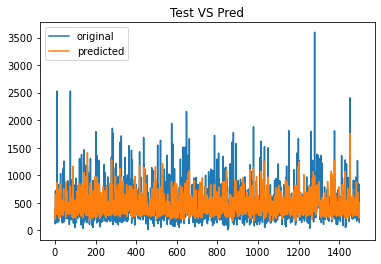

In [37]:
x_ax = range(len(act))
plt.plot(x_ax, act, label="original")
plt.plot(x_ax, pred + 25, label="predicted")
plt.title("Test VS Pred")
plt.legend()
plt.show()

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
def create_deep_model(X, y, X_val, y_val):
#    act_f = tf.keras.layers.LeakyReLU(alpha=0.01)
    act_f = tf.nn.relu
    input_layer = keras.Input(shape=(X.shape[1],), name='input_layer')

    dense_layer = layers.Dense(32, kernel_initializer='normal',activation=act_f, name='dense_layer_1')(input_layer)
    dense_layer = layers.Dense(64, kernel_initializer='normal',activation=act_f, name='dense_layer_2')(dense_layer)
    dense_layer = layers.Dense(128, kernel_initializer='normal',activation=act_f, name='dense_layer_3')(dense_layer)
    dense_layer = layers.Dense(256, kernel_initializer='normal',activation=act_f, name='dense_layer_4')(dense_layer)
    dense_layer = layers.Dense(512, kernel_initializer='normal',activation=act_f, name='dense_layer_5')(dense_layer)
    

    output_layer = layers.Dense(1, name='output_layer')(dense_layer)

    model = keras.Model( inputs = [input_layer], 
                           outputs = [output_layer], name="reg_model")

    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    stop_callback = keras.callbacks.EarlyStopping(monitor='mae', mode='min', patience=10)
    model.fit(X, y, batch_size=16, epochs=100, validation_data=(X_val, y_val),
          callbacks=[stop_callback], verbose=1)
        
    return model




In [ ]:
model = create_deep_model(X_train, y_train, X_test, y_test)


Epoch 1/100
219/219 [==============================] - 3s 7ms/step - loss: 4.8371 - mae: 1.0106 - mse: 4.8371 - val_loss: 0.4615 - val_mae: 0.5349 - val_mse: 0.4615
Epoch 2/100
219/219 [==============================] - 1s 6ms/step - loss: 0.4813 - mae: 0.5264 - mse: 0.4813 - val_loss: 0.4337 - val_mae: 0.5117 - val_mse: 0.4337
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 0.4977 - mae: 0.5377 - mse: 0.4977 - val_loss: 0.4069 - val_mae: 0.4968 - val_mse: 0.4069
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3965 - mae: 0.4800 - mse: 0.3965 - val_loss: 0.3095 - val_mae: 0.4303 - val_mse: 0.3095
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3482 - mae: 0.4520 - mse: 0.3482 - val_loss: 0.3268 - val_mae: 0.4353 - val_mse: 0.3268
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.3455 - mae: 0.4485 - mse: 0.3455 - val_loss: 0.3062 - val_mae: 0.4305 - val_mse: 0.3062
Epoch 7/10

219/219 [==============================] - 1s 3ms/step - loss: 0.3129 - mae: 0.4265 - mse: 0.3129 - val_loss: 0.3275 - val_mae: 0.4545 - val_mse: 0.3275
Epoch 51/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3278 - mae: 0.4393 - mse: 0.3278 - val_loss: 0.3603 - val_mae: 0.4662 - val_mse: 0.3603
Epoch 52/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3181 - mae: 0.4325 - mse: 0.3181 - val_loss: 0.3366 - val_mae: 0.4627 - val_mse: 0.3366
Epoch 53/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3174 - mae: 0.4314 - mse: 0.3174 - val_loss: 0.3180 - val_mae: 0.4468 - val_mse: 0.3180
Epoch 54/100
209/219 [===========================>..] - ETA: 0s - loss: 0.3096 - mae: 0.4268 - mse: 0.3096

In [ ]:
check_model_accuracy([model], X_train, X_test, y_train, y_test)

In [ ]:
pred[:2].reshape(-1,).shape

In [ ]:
act=np.expm1(y_train[:20]).values
pred=np.expm1(model.predict(X_train.iloc[:20, :]))



pd.DataFrame({'Predicted':pred[:20].reshape(-1,), 'Actual':act[:20].reshape(-1,)}, index=range(20))